Regresión Logística con Descenso del Gradiente 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dataset_phishing_processed.csv') # Cargar el dataset 

print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.") #prueba del dataset
df.head()

Dataset cargado con 11430 filas y 3 columnas.


,nb_www,ratio_digits_url,status
0,1.098907,-0.594651,0
1,-0.893559,1.876053,1
2,-0.893559,1.092856,1
3,-0.893559,-0.594651,0
4,1.098907,-0.594651,0


In [25]:
features = ['nb_www', 'ratio_digits_url']  #  Selección de variables para la visualización (nb_hyperlinks, ratio_extHyperlinks) (nb_www, nb_dots)buena pareja tamb
X = df[features].values.astype(float)
y = df['status'].values.reshape(-1, 1)

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_norm = (X - X_mean) / X_std

print("Pre-procesamiento completado y datos normalizados.")

Pre-procesamiento completado y datos normalizados.


In [26]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, w, b): #Hipótesis: y_hat = g(Xw + b)
    return sigmoid(np.dot(X, w) + b) 

def compute_log_loss(y, y_hat): #Binary Cross-Entropy
    m = len(y)
    epsilon = 1e-15
    loss = - (1/m) * np.sum(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
    return loss

def gradient_descent(X, y, learning_rate, epochs): #Descenso del Gradiente
    m, n = X.shape
    w = np.zeros((n, 1))
    b = 0
    loss_history = []

    for i in range(epochs):
        # Forward pass (Prediccion)
        y_hat = predict(X, w, b)
        
        # Calculo de Gradientes (Derivadas matriciales)
        error = y_hat - y
        dw = (1/m) * np.dot(X.T, error)
        db = (1/m) * np.sum(error)
        
        # Actualizacion de parametros
        w -= learning_rate * dw
        b -= learning_rate * db
        
        # Registro del historial de prrdida
        current_loss = compute_log_loss(y, y_hat)
        loss_history.append(current_loss)
        
        if i % 100 == 0:
            print(f"Epoca {i}: Perdida = {current_loss:.4f}")
            
    return w, b, loss_history

LR = 0.1
EPOCHS = 1000

w_final, b_final, history = gradient_descent(X_norm, y, LR, EPOCHS)

Epoca 0: Perdida = 0.6931
Epoca 100: Perdida = 0.5426
Epoca 200: Perdida = 0.5388
Epoca 300: Perdida = 0.5384
Epoca 400: Perdida = 0.5383
Epoca 500: Perdida = 0.5383
Epoca 600: Perdida = 0.5383
Epoca 700: Perdida = 0.5383
Epoca 800: Perdida = 0.5383
Epoca 900: Perdida = 0.5383


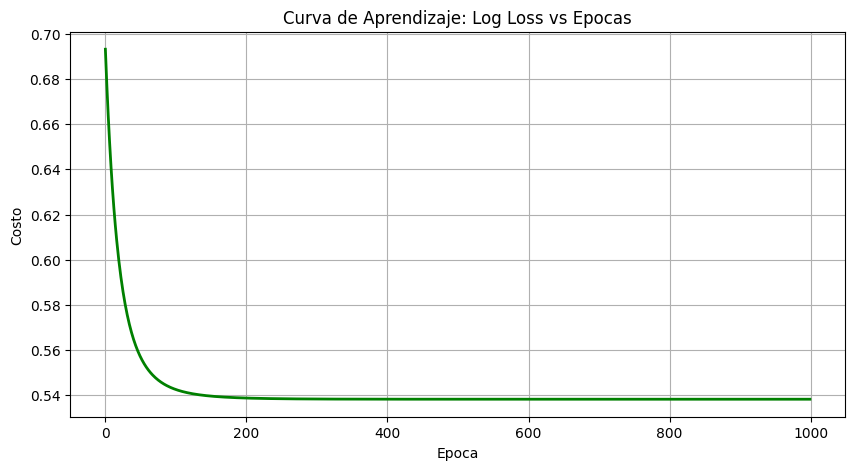

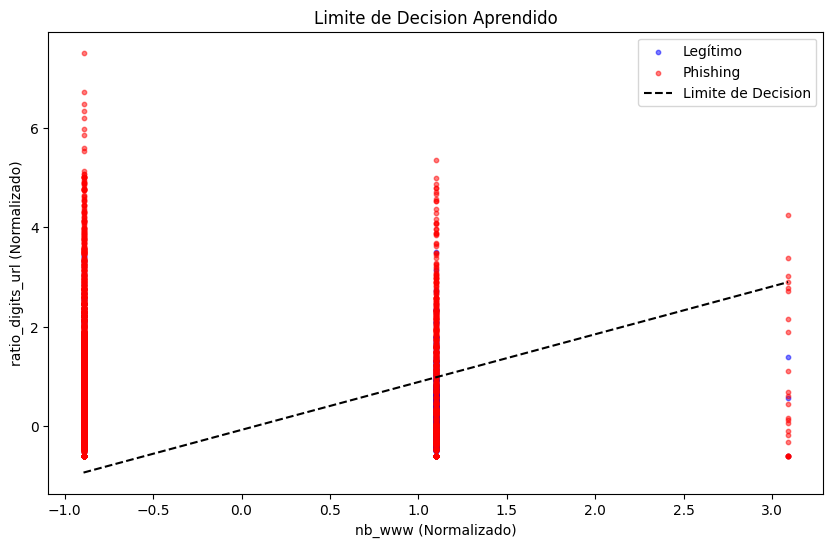

In [27]:
# Grafica de Costo 
plt.figure(figsize=(10, 5))
plt.plot(history, color='green', linewidth=2)
plt.title('Curva de Aprendizaje: Log Loss vs Epocas')
plt.xlabel('Epoca')
plt.ylabel('Costo')
plt.grid(True)
plt.show()

# Threshold de Decision 
plt.figure(figsize=(10, 6))

plt.scatter(X_norm[y.flatten() == 0, 0], X_norm[y.flatten() == 0, 1], 
            color='blue', label='Legítimo', alpha=0.5, s=10)
plt.scatter(X_norm[y.flatten() == 1, 0], X_norm[y.flatten() == 1, 1], 
            color='red', label='Phishing', alpha=0.5, s=10)

# w1*x1 + w2*x2 + b = 0  => x2 = -(w1*x1 + b) / w2
x1_vals = np.linspace(X_norm[:, 0].min(), X_norm[:, 0].max(), 100)
x2_vals = -(w_final[0] * x1_vals + b_final) / w_final[1]

plt.plot(x1_vals, x2_vals, color='black', linestyle='--', label='Limite de Decision')

plt.title('Limite de Decision Aprendido')
plt.xlabel(f'{features[0]} (Normalizado)')
plt.ylabel(f'{features[1]} (Normalizado)')
plt.legend()
plt.show()

K-Nearest Neighbours Manual 

In [28]:
def euclidean_distance(point, data): # sqrt(sum((p1 - p2)^2))
    return np.sqrt(np.sum((point - data)**2, axis=1))

def predict_knn(X_train, y_train, X_test, k):
    y_pred = []
    
    for test_point in X_test:
        distances = euclidean_distance(test_point, X_train)

        k_indices = np.argsort(distances)[:k]
        
        k_nearest_labels = y_train[k_indices].flatten()
        
        counts = np.bincount(k_nearest_labels.astype(int))
        most_common = np.argmax(counts)
        
        y_pred.append(most_common)
        
    return np.array(y_pred)

In [29]:
K = 3

y_pred_knn = predict_knn(X_norm, y, X_norm, k=K)

print(f"Predicciones para los primeros 5 elementos: {y_pred_knn[:5]}")

Predicciones para los primeros 5 elementos: [0 1 1 1 0]


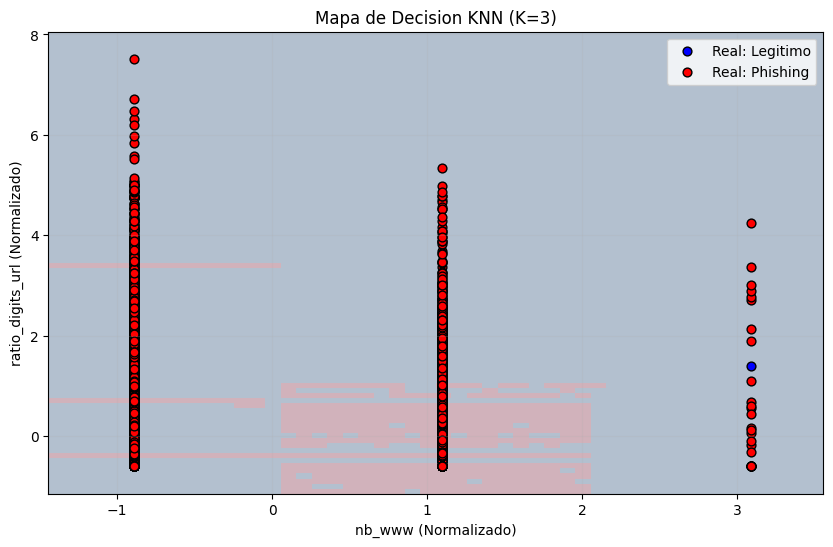

In [30]:
x_min, x_max = X_norm[:, 0].min() - 0.5, X_norm[:, 0].max() + 0.5
y_min, y_max = X_norm[:, 1].min() - 0.5, X_norm[:, 1].max() + 0.5


h = 0.1 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = predict_knn(X_norm, y, grid_points, k=K)

Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))# Graficar

plt.pcolormesh(xx, yy, Z, cmap='RdBu', alpha=0.3, shading='auto')

# Superponer los puntos reales
plt.scatter(X_norm[y.flatten() == 0, 0], X_norm[y.flatten() == 0, 1], 
            color='blue', label='Real: Legitimo', edgecolors='k', s=40)
plt.scatter(X_norm[y.flatten() == 1, 0], X_norm[y.flatten() == 1, 1], 
            color='red', label='Real: Phishing', edgecolors='k', s=40)

plt.title(f'Mapa de Decision KNN (K={K})')
plt.xlabel(f'{features[0]} (Normalizado)')
plt.ylabel(f'{features[1]} (Normalizado)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()